In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image 
import os
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DIR = "/content/drive/MyDrive/OMSCS/DL/FinalProject"
DATA_DIR = f'{DIR}/data'
NAME = 'cifar10'
DATA_SET_CLASS = torchvision.datasets.CIFAR10
image_size = 32
in_channels = 3
fgsm_alpha = 0.5
fgsm_epsilon = 0.007

sys.path.append(os.path.abspath(DIR))

import team36
from team36.mnist.vgg import VGG
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.defenses.fast_gradient_sign_method_loss import FastGradientSignMethodLoss
from team36.training import validate, accuracy, predict

In [3]:
model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    model = model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
model.load_state_dict(state_dict)

defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    defense_model = defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-examples-defense-{fgsm_epsilon}.pth")
defense_model.load_state_dict(state_dict)

criterion = nn.CrossEntropyLoss()

fgsm_reg_defense_model = VGG(image_size=image_size, in_channels=in_channels)
if torch.cuda.is_available():
    fgsm_reg_defense_model = fgsm_reg_defense_model.cuda()
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg-training-with-fgsm-regularization-defense-{fgsm_epsilon}.pth")
fgsm_reg_defense_model.load_state_dict(state_dict)

cpu_model = VGG(image_size=image_size, in_channels=in_channels)
state_dict = torch.load(f"{DIR}/checkpoints/{NAME}-vgg.pth")
cpu_model.load_state_dict(state_dict)
fgsm_reg_defense_criterion = FastGradientSignMethodLoss(cpu_model, nn.CrossEntropyLoss(), 
                                                        alpha=fgsm_alpha, epsilon=fgsm_epsilon)

In [4]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)
defense_test_accuracy, _, defense_test_loss = validate(None, test_loader, defense_model, criterion)
fgsm_reg_defense_test_accuracy, _, fgsm_reg_defense_test_loss = validate(None, test_loader,
                                                                         fgsm_reg_defense_model, 
                                                                         fgsm_reg_defense_criterion,
                                                                         no_grad=False)

print("No Attack")
print(f"Test Accuracy is {test_accuracy}")
print(f"Test Loss is {test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {fgsm_reg_defense_test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {defense_test_loss}")

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


No Attack
Test Accuracy is 0.7566999793052673
Test Loss is 0.7503899942398071
FGSM Examples Defense Test Accuracy is 0.7805999517440796
FGSM Examples Defense Test Loss is 0.7002246963500977
FGSM Regularization Defense Test Accuracy is 0.770799994468689
FGSM Regularization Defense Test Loss is 0.7094137447357177


In [5]:
test_set = DATA_SET_CLASS(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
attack_test_set = FastSignGradientAttackDataSet(test_set, model, criterion, epsilon=fgsm_epsilon, device='cuda')
attack_test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False)

attack_test_accuracy, _, attack_test_loss = validate(None, attack_test_loader, model, criterion)
attack_defense_test_accuracy, _, attack_defense_test_loss = validate(None, attack_test_loader, 
                                                                     defense_model, criterion)
attack_fgsm_reg_defense_test_accuracy, _, attack_fgsm_reg_defense_test_loss = validate(
    None, attack_test_loader, fgsm_reg_defense_model, fgsm_reg_defense_criterion, no_grad=False)


print("Attack")
print(f"Test Accuracy is {attack_test_accuracy}")
print(f"Test Loss is {attack_test_loss}")

print(f"FGSM Regularization Defense Test Accuracy is {attack_fgsm_reg_defense_test_accuracy}")
print(f"FGSM Regularization Defense Test Loss is {attack_fgsm_reg_defense_test_loss}")

print(f"FGSM Examples Defense Test Accuracy is {attack_defense_test_accuracy}")
print(f"FGSM Examples Defense Test Loss is {attack_defense_test_loss}")

Files already downloaded and verified
Attack
Test Accuracy is 0.5153999924659729
Test Loss is 1.3501220548152923
FGSM Examples Defense Test Accuracy is 0.6926999688148499
FGSM Examples Defense Test Loss is 0.9095079731941224
FGSM Regularization Defense Test Accuracy is 0.6182000041007996
FGSM Regularization Defense Test Loss is 1.0851730012893677


ground truth 8
no attack 8


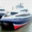


attack, no defense 1


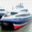


attack, FGSM training defense 8


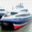


attack, FGSM loss defense 8


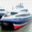

In [6]:
index = 1 # mnist
# index = 0 # cifar10

input, ground_truth = test_set[index]
input = input.cuda()

print("ground truth", ground_truth)

print("no attack", predict(model, input))
display(transforms.functional.to_pil_image(input))
print()

adversarial_input, _ = attack_test_set[index]
adversarial_input = adversarial_input.cuda()

print("attack, no defense", predict(model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM training defense", predict(defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

print("attack, FGSM loss defense", predict(fgsm_reg_defense_model, adversarial_input))
display(transforms.functional.to_pil_image(adversarial_input))
print()

image_dir = f"{DIR}/images"

pil_image = transforms.functional.to_pil_image(input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}.png")

pil_image = transforms.functional.to_pil_image(adversarial_input)
pil_image.save(f"{image_dir}/{NAME}-{str(index)}-{fgsm_epsilon}-fgsm-adversarial.png")